In [110]:
import sys
if '../' not in sys.path:
    sys.path.append("../")
%load_ext dotenv
%reload_ext dotenv
%dotenv

import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.pyplot import figure

from queries import pyg_queries, utils
from config.base import MODEL_CFG, DATASET_CFG

from queries.feature_queries import (
    IdentityEncoder,
    ListEncoder,
    load_edge_tensor,
    load_node_tensor,
)
from queries.utils import read_ddf_from_disk
from models.models_v3 import Model
from config.base import (
    DIR_CFG,
    MODEL_CFG,
    DATASET_CFG,
)

import numpy as np
import pandas as pd
import umap
import seaborn as sns

from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)

import torch
from torch_geometric import seed_everything
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T
import torch.nn.functional as F

seed_everything(MODEL_CFG['RANDOM_SEED'])


The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [280]:
class RandomValueEncoder(object):
    def __init__(self, dim=1):
        self.dim = dim

    def __call__(self, df):
        return torch.rand(len(df), self.dim)


def create_pyg_graph(
    sampling_rate=MODEL_CFG['SAMPLING_RATIO'],
    dataset_cfg=DATASET_CFG,
):
    data = HeteroData()
    mappings = {}
    # dir_name = f"{DIR_CFG['DATASETS_DIR']}{sampling_rate}"
    dir_name = f"{DIR_CFG['DATASETS_DIR']}0.1"
    # dir_name = f"{DIR_CFG['DATASETS_DIR']}1"
    # dir_name = f"{DIR_CFG['DATASETS_DIR']}apicomplexa"
    node_file_paths = list(
        map(
            (lambda cfg: cfg['FILE_NAME']),
            dataset_cfg['NODE_TYPES']
        )
    )
    rel_file_paths = list(
        map(
            (lambda cfg: cfg['FILE_NAME']),
            dataset_cfg['REL_TYPES']
        )
    )

    if 'taxon_nodes.csv' in node_file_paths:
        taxon_x, taxon_mapping = load_node_tensor(
            filename=f'{dir_name}/taxon_nodes.csv',
            index_col='appId',
            encoders={
                # 'rankEncoded': IdentityEncoder(
                #     dtype=torch.long, is_tensor=True),
                'features': ListEncoder(),
                # 'features': RandomValueEncoder(),
                # 'FastRP_embedding': ListEncoder(),
            }
        )
        data['taxon'].node_id = torch.arange(len(taxon_x))
        data['taxon'].x = taxon_x
        mappings['taxon'] = taxon_mapping

    if 'sotu_nodes.csv' in node_file_paths:
        sotu_x, sotu_mapping = load_node_tensor(
            filename=f'{dir_name}/sotu_nodes.csv',
            index_col='appId',
            encoders={
                # 'centroidEncoded': IdentityEncoder(
                #   dtype=torch.long, is_tensor=True),
                'features': ListEncoder(),
                # 'features': RandomValueEncoder(),
                # 'FastRP_embedding': ListEncoder(),
            }
        )
        data['sotu'].node_id = torch.arange(len(sotu_x))
        data['sotu'].x = sotu_x #torch.arange(0, len(sotu_mapping))
        mappings['sotu'] = sotu_mapping

    # if 'tissue_nodes.csv' in node_file_paths:
    #     tissue_x, tissue_mapping = load_node_tensor(
    #         filename=f'{dir_name}/tissue_nodes.csv',
    #         index_col='appId',
    #         encoders={
    #             # 'centroidEncoded': IdentityEncoder(
    #             #   dtype=torch.long, is_tensor=True),
    #             # 'features': ListEncoder(),
    #             'FastRP_embedding': ListEncoder(),
    #         }
    #     )
    #     data['tissue'].x = tissue_x # torch.arange(0, len(tissue_mapping))
    #     mappings['tissue'] = tissue_mapping

    if 'sotu_has_host_stat_edges.csv' in rel_file_paths:
        edge_index, edge_label = load_edge_tensor(
            filename=f'{dir_name}/sotu_has_host_stat_edges.csv',
            src_index_col='sourceAppId',
            src_mapping=sotu_mapping,
            dst_index_col='targetAppId',
            dst_mapping=taxon_mapping,
            # encoders={
            #     'weight': IdentityEncoder(dtype=torch.float, is_tensor=True),
            #     'weight': BinaryEncoder(dtype=torch.long),
            # },
        )
        # edge_label = torch.div(edge_label, 100)
        data['sotu', 'has_host', 'taxon'].edge_index = edge_index
        data['sotu', 'has_host', 'taxon'].edge_label = edge_label

    if 'taxon_has_parent_edges.csv' in rel_file_paths:
        edge_index, edge_label = load_edge_tensor(
            filename=f'{dir_name}/taxon_has_parent_edges.csv',
            src_index_col='sourceAppId',
            src_mapping=taxon_mapping,
            dst_index_col='targetAppId',
            dst_mapping=taxon_mapping,
            encoders={
                'weight': IdentityEncoder(dtype=torch.float, is_tensor=True)
            },
        )
        data['taxon', 'has_parent', 'taxon'].edge_index = edge_index
        data['taxon', 'has_parent', 'taxon'].edge_label = edge_label

    # if 'tissue_has_parent_edges.csv' in rel_file_paths:
    #     edge_index, edge_label = load_edge_tensor(
    #         filename=f'{dir_name}/tissue_has_parent_edges.csv',
    #         src_index_col='sourceAppId',
    #         src_mapping=tissue_mapping,
    #         dst_index_col='targetAppId',
    #         dst_mapping=tissue_mapping,
    #         encoders={
    #             'weight': IdentityEncoder(dtype=torch.float, is_tensor=True)
    #         },
    #     )
    #     data['tissue', 'has_parent', 'tissue'].edge_index = edge_index
    #     data['tissue', 'has_parent', 'tissue'].edge_label = edge_label

    if 'sotu_sequence_alignment_edges.csv' in rel_file_paths:
        edge_index, edge_label = load_edge_tensor(
            filename=f'{dir_name}/sotu_sequence_alignment_edges.csv',
            src_index_col='sourceAppId',
            src_mapping=sotu_mapping,
            dst_index_col='targetAppId',
            dst_mapping=sotu_mapping,
            encoders={
                'weight': IdentityEncoder(dtype=torch.float, is_tensor=True)
            },
        )
        data['sotu', 'sequence_alignment', 'sotu'].edge_index = edge_index
    #     data['sotu', 'sequence_alignment', 'sotu'].edge_label = edge_label

    if 'sotu_has_inferred_taxon_edges.csv' in rel_file_paths:
        edge_index, edge_label = load_edge_tensor(
            filename=f'{dir_name}/sotu_has_inferred_taxon_edges.csv',
            src_index_col='sourceAppId',
            src_mapping=sotu_mapping,
            dst_index_col='targetAppId',
            dst_mapping=taxon_mapping,
            encoders={
                'weight': IdentityEncoder(dtype=torch.float, is_tensor=True)
            },
        )
        data['sotu', 'has_inferred_taxon', 'taxon'].edge_index = edge_index
        data['sotu', 'has_inferred_taxon', 'taxon'].edge_label = edge_label

    node_types, edge_types = data.metadata()
    # data = T.ToUndirected()(data)
    if not ('taxon', 'rev_has_host', 'sotu') in edge_types:
        data = T.ToUndirected()(data)
        # Remove "reverse" label. (redundant if using link loader)
        del data['taxon', 'rev_has_host', 'sotu'].edge_label
    return data, mappings


In [281]:
data, mappings = create_pyg_graph()
print(data)

HeteroData(
  taxon={
    node_id=[250187],
    x=[250187, 1],
  },
  sotu={
    node_id=[51318],
    x=[51318, 1],
  },
  (sotu, has_host, taxon)={ edge_index=[2, 6789] },
  (taxon, has_parent, taxon)={
    edge_index=[2, 494426],
    edge_label=[494426],
  },
  (sotu, sequence_alignment, sotu)={ edge_index=[2, 154486] },
  (sotu, has_inferred_taxon, taxon)={
    edge_index=[2, 54544],
    edge_label=[54544],
  },
  (taxon, rev_has_host, sotu)={ edge_index=[2, 6789] },
  (taxon, rev_has_inferred_taxon, sotu)={
    edge_index=[2, 54544],
    edge_label=[54544],
  }
)


[('9443', 4383), ('9989', 4140), ('2732544', 2839), ('94695', 2830), ('186826', 2729), ('91347', 2719), ('13792', 2654), ('80840', 2622), ('7147', 2262), ('2191', 1829)]


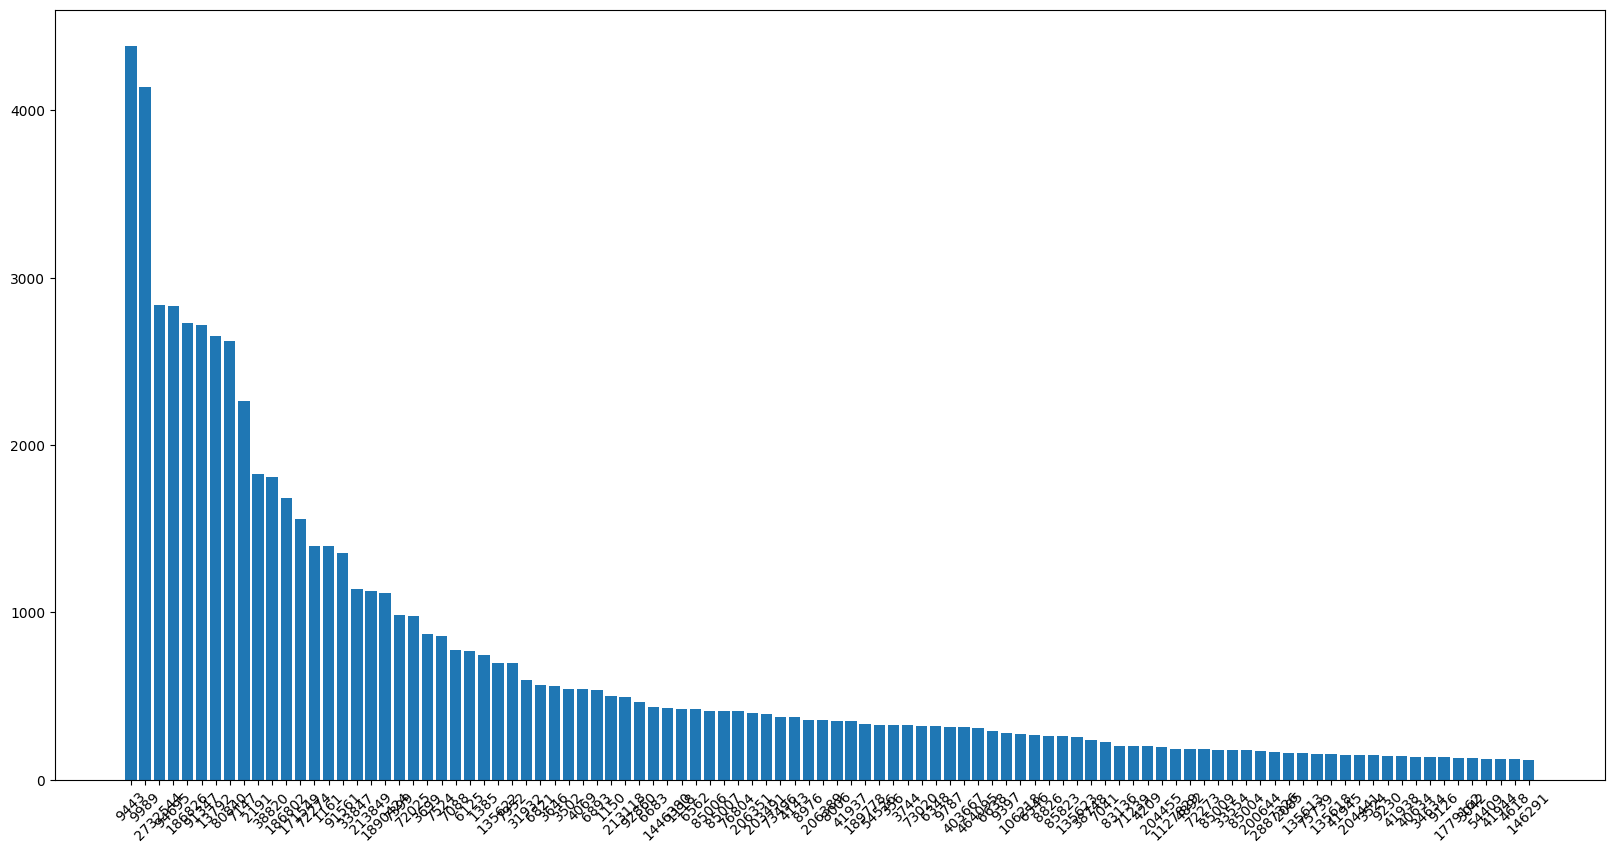

In [24]:
inv_taxon_map = {v: k for k, v in mappings['taxon'].items()}
plot_data = data['sotu', 'has_host', 'taxon'].edge_index[1].cpu().numpy()
plot_data = [
    str(inv_taxon_map[node_id])
    for node_id in plot_data
]
c = Counter(plot_data)
print(c.most_common(10))

most_common = dict(c.most_common(100))
figure(figsize=(20, 10))
plt.bar(most_common.keys(), most_common.values())
plt.xticks(rotation=45)
plt.show()

In [282]:
transform = T.RandomLinkSplit(
    num_val=0.1, #0.1 
    num_test=0.1, #0.1
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=100.0,
    add_negative_train_samples=False,
    edge_types=("sotu", "has_host", "taxon"),
    rev_edge_types=("taxon", "rev_has_host", "sotu"), 
)

train_data, val_data, test_data = transform(data)

In [283]:
edge_label_index = train_data["sotu", "has_host", "taxon"].edge_label_index
edge_label = train_data["sotu", "has_host", "taxon"].edge_label

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[100, 50],
    neg_sampling_ratio=100.0,
    edge_label_index=(("sotu", "has_host", "taxon"), edge_label_index),
    edge_label=edge_label,
    batch_size=2048,
    shuffle=True,
)

# sampled_data = next(iter(train_loader))
# print(sampled_data["sotu", "has_host", "taxon"].edge_label.min())
# print(sampled_data)

In [286]:
print(data.metadata())


(['taxon', 'sotu'], [('sotu', 'has_host', 'taxon'), ('taxon', 'has_parent', 'taxon'), ('sotu', 'sequence_alignment', 'sotu'), ('sotu', 'has_inferred_taxon', 'taxon'), ('taxon', 'rev_has_host', 'sotu'), ('taxon', 'rev_has_inferred_taxon', 'sotu')])


In [289]:
from torch_geometric.nn import SAGEConv, to_hetero, GATConv
import torch.nn.functional as F


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # self.conv1 = SAGEConv((-1, -1), hidden_channels)
        # self.conv2 = SAGEConv((-1, -1), out_channels)
        self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.conv2 = GATConv((-1, -1), out_channels, add_self_loops=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class TaxonEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(-1, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.lin(x)


class SOTUEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['sotu'][row], z_dict['taxon'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, num_sotus, num_taxons, hidden_channels, out_channels):
        super().__init__()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.sotu_lin = torch.nn.Linear(1, hidden_channels)
        self.taxon_lin = torch.nn.Linear(1, hidden_channels)
        
        self.sotu_emb = torch.nn.Embedding(
            num_sotus, hidden_channels, device=device)
        self.taxon_emb = torch.nn.Embedding(
            num_taxons, hidden_channels, device=device)

        # test
        self.sotu_encoder = SOTUEncoder(hidden_channels, out_channels)
        # self.sotu_encoder = to_hetero(self.sotu_encoder, metadata=data.metadata())

        self.taxon_encoder = TaxonEncoder(hidden_channels, out_channels)
        # self.taxon_encoder = to_hetero(self.taxon_encoder, metadata=data.metadata())
        self.decoder = EdgeDecoder(out_channels)

        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels, out_channels)

        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())

    def forward(self, data, embeddings=False):
        # x_dict = data['x_dict']
        edge_index_dict = data.edge_index_dict
        edge_label_index = data['sotu', 'has_host', 'taxon'].edge_label_index

        x_dict = {
          "sotu": self.sotu_lin(data.x_dict["sotu"]) + self.sotu_emb(data["sotu"].n_id),
          "taxon": self.taxon_lin(data.x_dict["taxon"]) + self.taxon_emb(data["taxon"].n_id),
        }
        # x_dict['sotu'] = self.sotu_emb(data["sotu"].node_id),
        # x_dict['taxon'] =  self.taxon_lin(data["taxon"].x) + self.taxon_emb(data["taxon"].node_id),
        
        # x_dict['sotu'] = self.sotu_emb(x_dict['sotu'].long())
        # x_dict['taxon'] = self.taxon_emb(x_dict['taxon'].long())

        # x_dict = self.gnn(x_dict, data.edge_index_dict)


        z_dict = {}
        z_dict['sotu'] = self.sotu_encoder(
            x_dict['sotu'], 
            edge_index_dict[('sotu', 'sequence_alignment', 'sotu')],,
            # edge_index_dict,
        )
        z_dict['taxon'] = self.taxon_encoder(
            x_dict['taxon'],
            edge_index_dict[('taxon', 'has_parent', 'taxon')],
            # edge_index_dict,
        )

        # z_dict = self.gnn(x_dict, edge_index_dict)
        # if embeddings:
        #     return x_dict

        return self.decoder(z_dict, edge_label_index)


        
model = Model(
    num_sotus=data['sotu'].num_nodes,
    num_taxons=data['taxon'].num_nodes,
    hidden_channels=64,
    out_channels=64,
)

print(model)

SyntaxError: invalid syntax (1056039174.py, line 107)

In [149]:
# from torch_geometric.nn import SAGEConv, to_hetero
# import torch.nn.functional as F

# class GNN(torch.nn.Module):
#     def __init__(self, hidden_channels):
#         super().__init__()

#         self.conv1 = SAGEConv(hidden_channels, hidden_channels)
#         self.conv2 = SAGEConv(hidden_channels, hidden_channels)

#     def forward(self, x, edge_index):
#         x = F.relu(self.conv1(x, edge_index))
#         x = self.conv2(x, edge_index)
#         return x


# class Classifier(torch.nn.Module):
#     def forward(self, x_user, x_movie, edge_label_index):
#         # Convert node embeddings to edge-level representations:
#         edge_feat_user = x_user[edge_label_index[0]]
#         edge_feat_movie = x_movie[edge_label_index[1]]

#         # Apply dot-product to get a prediction per supervision edge:
#         return (edge_feat_user * edge_feat_movie).sum(dim=-1)

# class Model(torch.nn.Module):
#     def __init__(self, hidden_channels):
#         super().__init__()
#         # Since the dataset does not come with rich features, we also learn two
#         # embedding matrices for users and movies:
#         self.movie_lin = torch.nn.Linear(1, hidden_channels)
#         self.user_emb = torch.nn.Embedding(data["sotu"].num_nodes, hidden_channels)
#         self.movie_emb = torch.nn.Embedding(data["taxon"].num_nodes, hidden_channels)

#         # Instantiate homogeneous GNN:
#         self.gnn = GNN(hidden_channels)

#         # Convert GNN model into a heterogeneous variant:
#         self.gnn = to_hetero(self.gnn, metadata=data.metadata())

#         self.classifier = Classifier()

#     def forward(self, data, embeddings=False):
#         x_dict = {
#           "sotu": self.user_emb(data["sotu"].node_id),
#           "taxon": self.movie_lin(data["taxon"].x) + self.movie_emb(data["taxon"].node_id),
#         } 

#         # `x_dict` holds feature matrices of all node types
#         # `edge_index_dict` holds all edge indices of all edge types
#         x_dict = self.gnn(x_dict, data.edge_index_dict)
        
#         if embeddings:
#             return x_dict

#         pred = self.classifier(
#             x_dict["sotu"],
#             x_dict["taxon"],
#             data["sotu", "has_host", "taxon"].edge_label_index,
#         )

#         return pred

        
# model = Model(hidden_channels=64)

# print(model)

Model(
  (movie_lin): Linear(in_features=1, out_features=64, bias=True)
  (user_emb): Embedding(51318, 64)
  (movie_emb): Embedding(250187, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (sotu__has_host__taxon): SAGEConv(64, 64, aggr=mean)
      (taxon__has_parent__taxon): SAGEConv(64, 64, aggr=mean)
      (sotu__sequence_alignment__sotu): SAGEConv(64, 64, aggr=mean)
      (sotu__has_inferred_taxon__taxon): SAGEConv(64, 64, aggr=mean)
      (taxon__rev_has_host__sotu): SAGEConv(64, 64, aggr=mean)
      (taxon__rev_has_inferred_taxon__sotu): SAGEConv(64, 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (sotu__has_host__taxon): SAGEConv(64, 64, aggr=mean)
      (taxon__has_parent__taxon): SAGEConv(64, 64, aggr=mean)
      (sotu__sequence_alignment__sotu): SAGEConv(64, 64, aggr=mean)
      (sotu__has_inferred_taxon__taxon): SAGEConv(64, 64, aggr=mean)
      (taxon__rev_has_host__sotu): SAGEConv(64, 64, aggr=mean)
      (taxon__rev_has_inferred_taxon__sotu): SAGEConv(64, 64, a

In [290]:
import tqdm
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



for epoch in range(1, 100):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        sampled_data.to(device)

        # orig = sampled_data['sotu', 'has_host', 'taxon'].edge_index[1]
        # rand = torch.randperm(orig.shape[0])
        # sampled_data['sotu', 'has_host', 'taxon'].edge_index[1] = orig[rand]
        
        # pred = model(sampled_data)
        
        pred = model(sampled_data)
        # pred = model(
        #     sampled_data.x_dict,
        #     sampled_data.edge_index_dict,
        #     sampled_data['sotu', 'has_host', 'taxon'].edge_label_index
        # )

        # ground_truth_orig = sampled_data["sotu", "has_host", "taxon"].edge_label
        # rand = torch.randperm(ground_truth_orig.shape[0])
        # ground_truth = ground_truth_orig[rand]

        ground_truth = sampled_data["sotu", "has_host", "taxon"].edge_label

        # print(torch.count_nonzero(pred), torch.count_nonzero(ground_truth))

        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)


        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cpu'


  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: `MessagePassing.propagate` only supports integer tensors of shape `[2, num_messages]`, `torch_sparse.SparseTensor` or `torch.sparse.Tensor` for argument `edge_index`.

In [267]:
edge_label_index = val_data["sotu", "has_host", "taxon"].edge_label_index
edge_label = val_data["sotu", "has_host", "taxon"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[100, 50],
    edge_label_index=(("sotu", "has_host", "taxon"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

# sampled_data = next(iter(val_loader))

# print("Sampled mini-batch:")
# print("===================")
# print(sampled_data)

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["sotu", "has_host", "taxon"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
aupr = average_precision_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")
print(f"Validation AUC-PR: {aupr:.4f}")

100%|██████████| 179/179 [00:01<00:00, 96.50it/s] 


Validation AUC: 0.0526
Validation AUC-PR: 0.0052


In [268]:
edge_label_index = test_data["sotu", "has_host", "taxon"].edge_label_index
edge_label = test_data["sotu", "has_host", "taxon"].edge_label

test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[100, 50],
    edge_label_index=(("sotu", "has_host", "taxon"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)


preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(test_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["sotu", "has_host", "taxon"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
aupr = average_precision_score(ground_truth, pred)
print()
print(f"Test AUC: {auc:.4f}")
print(f"Test AUC-PR: {aupr:.4f}")

100%|██████████| 179/179 [00:01<00:00, 96.58it/s]


Test AUC: 0.0533
Test AUC-PR: 0.0052


In [108]:

# x, edge_index = data['taxon'].x.to(device), data['sotu', 'has_host', 'taxon'].edge_index.to(device)
out = model.forward(data, True)
# print(out)
print(out['sotu'].shape)
print(out['taxon'].shape)

torch.Size([51318, 64])
torch.Size([250187, 64])


In [ ]:
palette = {}

for n, y in enumerate(set(data.y.numpy())):
    palette[y] = f'C{n}'

UMAP( verbose=True)
Sat Dec 30 03:32:14 2023 Construct fuzzy simplicial set
Sat Dec 30 03:32:14 2023 Finding Nearest Neighbors
Sat Dec 30 03:32:14 2023 Building RP forest with 64 trees
Sat Dec 30 03:32:49 2023 NN descent for 21 iterations
	 1  /  21
	 2  /  21
	 3  /  21
	 4  /  21
	 5  /  21
	 6  /  21
	 7  /  21
	 8  /  21
	 9  /  21
	Stopping threshold met -- exiting after 9 iterations
Sat Dec 30 03:34:51 2023 Finished Nearest Neighbor Search
Sat Dec 30 03:35:06 2023 Construct embedding


Epochs completed:   0%|            1/200 [00:01]

	completed  0  /  200 epochs


Epochs completed:  10%| █          21/200 [01:06]

	completed  20  /  200 epochs


Epochs completed:  20%| ██         41/200 [02:17]

	completed  40  /  200 epochs


Epochs completed:  30%| ███        61/200 [03:29]

	completed  60  /  200 epochs


Epochs completed:  40%| ████       81/200 [04:42]

	completed  80  /  200 epochs


Epochs completed:  50%| █████      101/200 [05:54]

	completed  100  /  200 epochs


Epochs completed:  60%| ██████     121/200 [07:06]

	completed  120  /  200 epochs


Epochs completed:  70%| ███████    141/200 [08:19]

	completed  140  /  200 epochs


Epochs completed:  80%| ████████   161/200 [09:40]

	completed  160  /  200 epochs


Epochs completed:  90%| █████████  181/200 [11:06]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [12:21]


Sat Dec 30 03:50:34 2023 Finished embedding


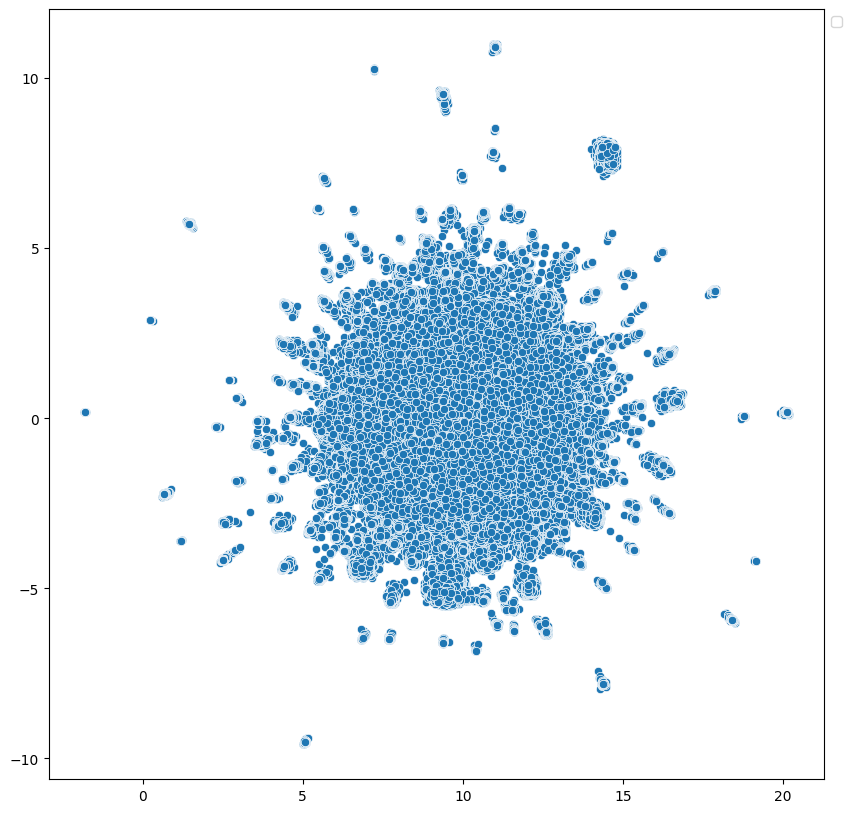

In [67]:
embd_taxon = umap.UMAP(verbose=True).fit_transform(out['taxon'].detach().numpy())


plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd_taxon.T[0], y=embd_taxon.T[1])
# sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

UMAP( verbose=True)
Sun Dec 31 02:47:12 2023 Construct fuzzy simplicial set
Sun Dec 31 02:47:12 2023 Finding Nearest Neighbors
Sun Dec 31 02:47:12 2023 Building RP forest with 16 trees
Sun Dec 31 02:47:13 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	Stopping threshold met -- exiting after 6 iterations
Sun Dec 31 02:47:14 2023 Finished Nearest Neighbor Search
Sun Dec 31 02:47:14 2023 Construct embedding


Epochs completed:   2%| ▏          4/200 [00:01]

	completed  0  /  200 epochs


Epochs completed:  11%| █          22/200 [00:02]

	completed  20  /  200 epochs


Epochs completed:  21%| ██         42/200 [00:04]

	completed  40  /  200 epochs


Epochs completed:  31%| ███        62/200 [00:05]

	completed  60  /  200 epochs


Epochs completed:  41%| ████       82/200 [00:07]

	completed  80  /  200 epochs


Epochs completed:  51%| █████      102/200 [00:08]

	completed  100  /  200 epochs


Epochs completed:  61%| ██████     122/200 [00:10]

	completed  120  /  200 epochs


Epochs completed:  71%| ███████    142/200 [00:11]

	completed  140  /  200 epochs


Epochs completed:  81%| ████████   162/200 [00:12]

	completed  160  /  200 epochs


Epochs completed:  91%| █████████  182/200 [00:14]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:15]


Sun Dec 31 02:47:36 2023 Finished embedding


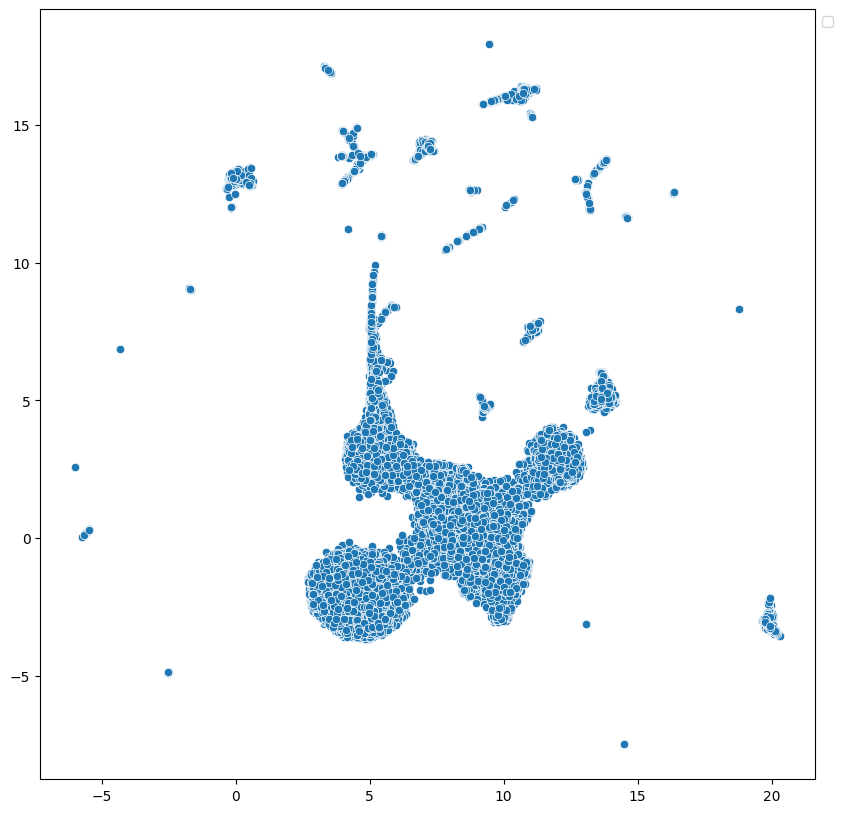

In [109]:
embd_sotu = umap.UMAP(verbose=True).fit_transform(out['sotu'].detach().numpy())

plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd_sotu.T[0], y=embd_sotu.T[1])
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

In [18]:
print(data['sotu'].x)

tensor([[0.1082],
        [0.0987],
        [0.1398],
        ...,
        [0.4216],
        [0.6746],
        [0.8746]])


In [69]:
embd_sotu = umap.UMAP(verbose=True).fit_transform(data['sotu'].x.detach().numpy())

plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd_sotu.T[0], y=embd_sotu.T[1])
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

UMAP( verbose=True)
Sat Dec 30 04:03:06 2023 Construct fuzzy simplicial set
Sat Dec 30 04:03:06 2023 Finding Nearest Neighbors
Sat Dec 30 04:03:06 2023 Building RP forest with 41 trees
Sat Dec 30 04:03:14 2023 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	 3  /  19
	 4  /  19
	Stopping threshold met -- exiting after 4 iterations
Sat Dec 30 04:03:34 2023 Finished Nearest Neighbor Search
Sat Dec 30 04:03:37 2023 Construct embedding
